<a href="https://colab.research.google.com/github/jj7258/Emotion-Identification/blob/main/Emotion_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Emotion Identification

In this notebook, we'll use machine learning to categorise the emotions included in audio recordings. After extracting characteristics from audio recordings with the librosa framework, we will train a neural network to categorise emotions.


## Importing libraries

First, we will start by importing the necessary libraries and ignoring warnings.



In [1]:
import warnings
warnings.filterwarnings('ignore')

import librosa
import os, glob, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from os import listdir

import librosa.display

## Extracting audio filenames and emotions

We start by collecting the audio filenames and corresponding emotions in separate lists. The path of the audio files and their emotions are stored in the variables audio_path and audio_emotion respectively. The emotions are extracted from the filenames.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = 'drive/MyDrive/AudioWAV/'
audio_path = []
audio_emotion = []

In [4]:
# collects all the audio filename in the variable 'path'
directory_path = listdir(path)

In [5]:
for audio in directory_path:
    audio_path.append(path + audio)
    emotion = audio.split('_')
    if emotion[2] == 'SAD':
        audio_emotion.append("sad")
    elif emotion[2] == 'ANG':
        audio_emotion.append("angry")
    elif emotion[2] == 'DIS':
        audio_emotion.append("disgust")
    elif emotion[2] == 'NEU':
        audio_emotion.append("neutral")
    elif emotion[2] == 'HAP':
        audio_emotion.append("happy")
    elif emotion[2] == 'FEA':
        audio_emotion.append("fear")
    else:
        audio_emotion.append("unknown")

In [6]:
emotion_dataset = pd.DataFrame(audio_emotion, columns=['Emotions'])
audio_path_dataset = pd.DataFrame(audio_path, columns=['Path'])
dataset = pd.concat([audio_path_dataset, emotion_dataset], axis= 1)

print(dataset.head())


                                         Path Emotions
0  drive/MyDrive/AudioWAV/1080_IEO_ANG_MD.wav    angry
1  drive/MyDrive/AudioWAV/1079_IWW_DIS_XX.wav  disgust
2  drive/MyDrive/AudioWAV/1079_IEO_DIS_LO.wav  disgust
3  drive/MyDrive/AudioWAV/1080_IEO_HAP_LO.wav    happy
4  drive/MyDrive/AudioWAV/1079_DFA_DIS_XX.wav  disgust


## Visualizing emotions

We can visualize the emotions of the audio files using a histogram.

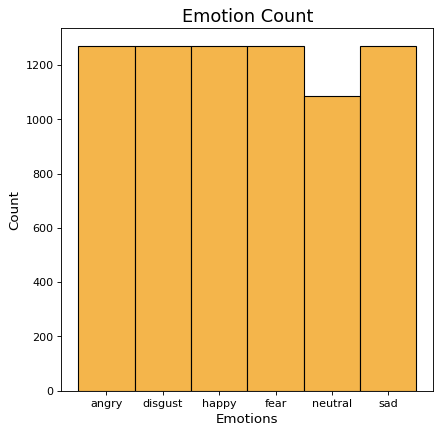

In [7]:
# counting audio categorized by emotions
plt.figure(figsize=(6,6), dpi=80)
plt.title("Emotion Count", size=16)
plt.xlabel('Emotions', size = 12)
plt.ylabel('Count', size = 12)
sns.histplot(dataset.Emotions, color='#F19C0E')


## Extracting features from audio files

Now, we will extract the necessary features from the audio files. We will extract the MFCC and Mel features from the audio files and store them in a dataframe along with the emotion label for each audio file.

In [8]:
X, Y = [], []
print("Feature processing...")

for path, emo, index in zip(dataset.Path, dataset.Emotions, range(len(dataset))):
    value, sample = librosa.load(path)
    # noise injection
    noise_amp = 0.035 * np.random.uniform() * np.amax(value)
    value = value + noise_amp * np.random.normal(size=value.shape[0])
    # mfcc
    mfcc = librosa.feature.mfcc(y=value, sr= sample, n_mfcc=13, n_fft=200, hop_length=512)
    mfcc = np.ravel(mfcc.T)
    # mel
    mel = librosa.feature.melspectrogram(y=value, sr=sample, hop_length = 256, n_fft = 512, n_mels=64)
    mel = librosa.power_to_db(mel ** 2)
    mel = np.ravel(mel).T
    result = np.array([])
    result = np.hstack((result, mfcc, mel))
  
    result = np.array(result)
    X.append(result)
    Y.append(emo)

Feature processing...


In [9]:

extracted_audio_df = pd.DataFrame(X)
extracted_audio_df["emotion_of_audio"] = Y
print(extracted_audio_df.shape)
print(extracted_audio_df.tail(10))
extracted_audio_df = extracted_audio_df.fillna(0)


(7442, 30457)
               0          1          2          3          4          5  \
7432 -795.797579 -32.120075  23.046704  20.396499  20.419560  20.065688   
7433 -828.718147   8.093675 -23.101560  35.270118   5.724489   0.590736   
7434 -515.626523 -83.889300  -2.958627  15.429383  20.102983  -4.664043   
7435 -701.837997 -75.252873   1.833795  13.191461  10.656882  -5.137151   
7436 -781.860726 -22.087140  17.749035  35.647971   7.380920  29.136822   
7437 -769.889357 -16.823679  -2.288254   7.396960  17.332083 -21.256827   
7438 -634.013960 -40.000047   9.136871  12.637184  22.042133   2.734228   
7439 -829.959454  13.008016  12.243181  20.267717  10.327020  19.111259   
7440 -604.716890 -84.585232 -31.522639  34.604999  30.765686 -16.539457   
7441 -649.839321 -56.461303  -7.821440  15.667959   9.210937  14.409639   

              6          7          8          9  ...  30447  30448  30449  \
7432 -13.830764  -8.657091 -15.793977  -8.671057  ...    NaN    NaN    NaN   
7433

## Preparing data for training

Now, we will split the data into training and testing sets and standardize the data using the StandardScaler function.


In [10]:
# preparing to train
X = extracted_audio_df.drop(labels='emotion_of_audio', axis= 1)
Y = extracted_audio_df['emotion_of_audio']

x_train, x_test, y_train, y_test = train_test_split(np.array(X), Y, test_size=0.2)

In [11]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Training the Model

Now, we will create an instance of the MLP Classifier from the sklearn.neural_network library and fit it to the training data.

In [15]:
mlp_model = MLPClassifier(activation='relu',
                         solver='sgd',
                         hidden_layer_sizes=100, 
                         alpha=0.839903176695813,
                         batch_size=150,
                         learning_rate='adaptive',
                         max_iter=100000)
# Fitting mlp model
mlp_model.fit(x_train,y_train)

MLPClassifier(alpha=0.839903176695813, batch_size=150, hidden_layer_sizes=100,
              learning_rate='adaptive', max_iter=100000, solver='sgd')

## Evaluating the Model

Now that the model is trained, we will evaluate its performance on the test data. We will use the accuracy_score function from the sklearn.metrics library to calculate the accuracy of the model.

In [16]:
y_pred = mlp_model.predict(x_test)
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

print("\nModel:{}    Accuracy: {:.2f}%".
          format(type(mlp_model).__name__ , accuracy*100))


Model:MLPClassifier    Accuracy: 40.43%


## Model Predictions

Finally, we can print out the predictions made by the model on the testing set.

In [17]:
print("The Model's Prediction ")
print("<<<===========================================>>>")
df = pd.DataFrame({'Actual': y_test, 'Predict': y_pred})
print(df.head())

The Model's Prediction 
<<<===========================================>>>
       Actual  Predict
2383    angry  neutral
6719    happy    happy
908     happy     fear
3067  disgust    angry
3165      sad      sad
